In [5]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import scipy 

import os
import bilby 
from bilby import gw
import gwinc
import wget
import lal
import lalpulsar
from lalpulsar.PulsarParametersWrapper import PulsarParametersPy
import dynesty
import pickle

(900, 2)


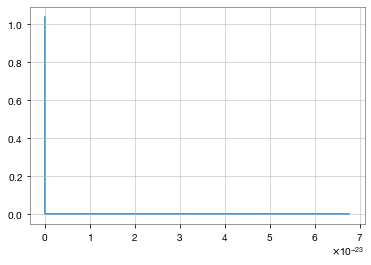

In [7]:

# Inject the signal into
duration = 4096.  #4096 seconds signal in total
sampling_frequency = 2.    #sampleing 2x4096 data segments

# Specify the output directory and the name of the simulation.
outdir = 'outdir3'
label = 'LISA_detector'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(42)

#get psd of LISA
temp=np.loadtxt('./lisa_psd.txt')
LISA_frequencies=temp[:,0]
LISA_psd=temp[:,1]
print(temp.shape)
#plt.plot(LISA_psd,LISA_frequencies)

# Set up new detector with parameters of LISA
LISA =bilby.gw.detector.Interferometer(
    power_spectral_density=bilby.gw.detector.PowerSpectralDensity(
        frequency_array=LISA_frequencies, psd_array=LISA_psd),
    name='LISA', length=2.5e6,
    minimum_frequency=1.0e-4, 
    maximum_frequency=1,
    latitude=-31.34, longitude=115.91,
    elevation=0., xarm_azimuth=2., yarm_azimuth=125.)

interferometers = bilby.gw.detector.InterferometerList([])

interferometers.append(LISA)

# Inject GW signal into the network (signal at 4 Gpc)
injection_parameters = dict(
    mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=400., theta_jn=0.4, psi=2.659,
    phase=1.3, ssb_time=1126259642.413, ra=1.375, dec=0.2108)
            
# specific a approximant waveform, start at minimum frequency 0.1Hz
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          #reference_frequency=1.0e-4,
                          minimum_frequency=0.5, reference_frequency=1e-1)

In [11]:
#Getting the ephemeris files which I have already downloaded.
earthstr = 'earth00-40-{}.dat.gz'
sunstr = 'sun00-40-{}.dat.gz'
timecorrstr = '{}_2000-2040.dat.gz'
# mapping between time units and time correction file prefix
units_map = {'TCB': 'te405',
            'TDB': 'tdb'}
ephem='DE405'
units='TDB'
earthfile = earthstr.format(ephem)
sunfile = sunstr.format(ephem)
timefile = timecorrstr.format(units_map[units])
DOWNLOAD_URL = 'https://git.ligo.org/lscsoft/lalsuite/-/raw/master/lalpulsar/lib/{}'
if not os.path.isfile(earthfile):
    wget.download(DOWNLOAD_URL.format(earthfile), './')
if not os.path.isfile(sunfile):
    wget.download(DOWNLOAD_URL.format(sunfile), './')
if not os.path.isfile(timefile):
    wget.download(DOWNLOAD_URL.format(timefile), './')
print(earthfile,sunfile,timefile)
#edat = lalpulsar.InitBarycenter('./earth00-40-DE405.dat.gz', './sun00-40-DE405.dat.gz')
edat = lalpulsar.InitBarycenter(earthfile,sunfile)
tdat = lalpulsar.InitTimeCorrections(timefile)

earth00-40-DE405.dat.gz sun00-40-DE405.dat.gz tdb_2000-2040.dat.gz


In [12]:
source = PulsarParametersPy()
source["RAJ"] = injection_parameters['ra'] # right ascension in radians -------(ra=1.375, dec=0.2108 for GW150914)
source["DECJ"] = injection_parameters['dec'] # declination in radians
#--------NOW CALLING THE SSB DELAY FUNCTION-------------------

det = 'H1'
detector = lalpulsar.GetSiteInfo(det)
detector.location=[0,0,0]
LISA_ssbtime = np.array([injection_parameters['ssb_time']-(365.25*86400*20/360.0)], dtype='float64')
#^^Finding the ssb_time corresponding to when the Earth was 20 degrees earlier in its orbit^^
# [ie: still an ssb_time, just an ssb_time in the past]

LISA_ssbtime_vector = lalpulsar.CreateTimestampVector(len(LISA_ssbtime)) #since SSBDelay function required input of this type
for i, time in enumerate(LISA_ssbtime): 
    LISA_ssbtime_vector.data[i] = lal.LIGOTimeGPS(time)
time_shift2 = lalpulsar.HeterodynedPulsarGetSSBDelay(source.PulsarParameters(), LISA_ssbtime_vector, detector, edat, tdat, lalpulsar.TIMECORRECTION_TDB)
#^^Finding the delay between ssb and LISA for 20 degrees in the past^^
#[ie: the time delay between the source signal arriving at SSB and then at LISA]


#start_time = injection_parameters['ssb_time'] + 2 - duration  #+2-duration(4096s) ensures 2 seconds of data after merger for 'safety'

start_time2 = (injection_parameters['ssb_time']+time_shift2.data[0])-1e7 #+ 2 - duration #for earth2   
print('time_shift2 is', time_shift2.data[0])
    #Correct time_shift for real earth is 19.91700987606675.
    #Correct time_shift for earth2 is -147.7005012566992.
print ('start_time2 is',start_time2 )

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, 
    waveform_arguments=waveform_arguments)

#set up interferometer about its sampling frequency, duration and start time.
for interferometer in interferometers:
    interferometer.set_strain_data_from_power_spectral_density(
        sampling_frequency=sampling_frequency, duration=duration,
     start_time=start_time2)
    
#IMPORTANT TO REMEMBER TO INJECT SIGNAL INTO INTERFEROMETERS.
    interferometer.inject_signal(
        parameters=injection_parameters, waveform_generator=waveform_generator)
    # plot the data for sanity
    signal = interferometer.get_detector_response(
        waveform_generator.frequency_domain_strain(injection_parameters), injection_parameters)
    interferometer.plot_data(signal=signal, outdir=outdir, label=label)
    
print('dt (LISA) is', injection_parameters['ssb_time']-start_time2+time_shift2.data[0])

/opt/anaconda3/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:19 bilby WARNING : Injecting signal outside segment, start_time=1116259494.712499, merger time=1126259642.413.
12:19 bilby INFO    : Injected signal in LISA:
12:19 bilby INFO    :   optimal SNR = 0.01
12:19 bilby INFO    :   matched filter SNR = 1.64-0.46j
12:19 bilby INFO    :   mass_1 = 36.0
12:19 bilby INFO    :   mass_2 = 29.0
12:19 bilby INFO    :   a_1 = 0.4
12:19 bilby INFO    :   a_2 = 0.3
12:19 bilby INFO    :   tilt_1 = 0.5
12:19 bilby INFO    :   tilt_2 = 1.0
12:19 bilby INFO    :   phi_12 = 1.7
12:19 bilby INFO    :   phi_jl = 0.3
12:19 bilby INFO    :   luminosity_distance = 400.0
12:19 bilby INFO    :   theta_jn = 0.4
12:19 bilby INFO    :   psi = 2.659
12:19 bilby INFO    :   phase = 1.3
12:19 bilby INFO    :   ssb_time = 1126259642.413
12:

time_shift2 is -147.7005012566992
start_time2 is 1116259494.712499
<Swig Object of type 'REAL8Vector *' at 0x1c1bea57f0>
<Swig Object of type 'REAL8Vector *' at 0x1c1beb3df0>
dt (LISA) is 9999999.999999946


<Swig Object of type 'REAL8Vector *' at 0x1c1a8666f0>


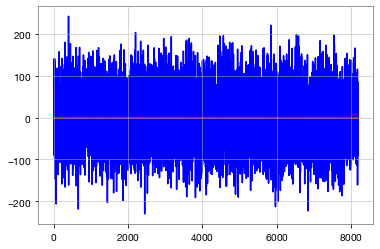

In [8]:
# compute the number of time domain samples
Nt = int(sampling_frequency*duration)

# extract waveform from bilgy
freq_signal = waveform_generator.frequency_domain_strain() 

# get frequency domain noise-free signal at detector
signal_fd = interferometers[0].get_detector_response(freq_signal, injection_parameters)

# whiten frequency domain noise-free signal (and reshape/flatten)
whitened_signal_fd = signal_fd/interferometers[0].amplitude_spectral_density_array

# get frequency domain signal + noise at detector
h_fd = interferometers[0].strain_data.frequency_domain_strain

whitened_signal_fd = np.nan_to_num(whitened_signal_fd)

# inverse FFT noise-free signal back to time domain and normalise
whitened_signal_td = np.sqrt(2.0*Nt)*np.fft.irfft(whitened_signal_fd)

# whiten noisy frequency domain signal
whitened_h_fd = h_fd/interferometers[0].amplitude_spectral_density_array

whitened_h_fd = np.nan_to_num(whitened_h_fd)

# inverse FFT noisy signal back to time domain and normalise
whitened_h_td = np.sqrt(2.0*Nt)*np.fft.irfft(whitened_h_fd)

plt.plot(whitened_h_td,'b-')
plt.plot(whitened_signal_td,'r-')




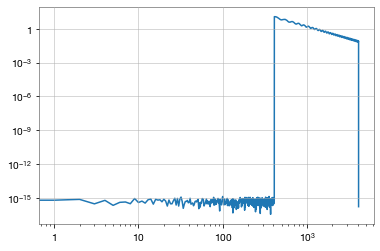

In [12]:
test=np.fft.rfft(whitened_signal_td)
#plt.plot(np.abs(test))
plt.loglog(np.abs(test))

In [ ]:
plt.plot(whitened_h_td)

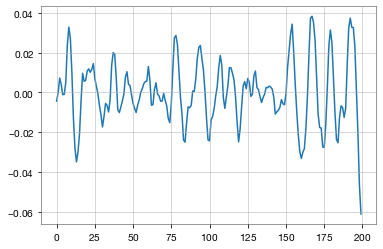

In [9]:
plt.plot(whitened_signal_td[-200:])

In [5]:
# set up priors. [Keep luminosity distance and sky location not fixed. Others fixed to save computational time]
priors = bilby.gw.prior.BBHPriorDict()
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi',
            'ssb_time', 'phase', 'mass_1', 'mass_2', 'theta_jn']:#, 'luminosity_distance']:#, 'ra', 'dec']: 
    priors[key] = injection_parameters[key]
    
# Initialise the likelihood by passing in the interferometer data (IFOs)
# and the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=interferometers, waveform_generator=waveform_generator,
    time_marginalization=False, phase_marginalization=False,
    distance_marginalization=False, priors=priors)
print('likelihood', likelihood)

13:48 bilby INFO    : No prior given, using default BBH priors in /opt/anaconda3/lib/python3.7/site-packages/bilby/gw/prior_files/binary_black_holes.prior.
13:48 bilby WARNING : The waveform_generator start_time is not equal to that of the provided interferometers. Overwriting the waveform_generator.


likelihood GravitationalWaveTransient(interferometers=[Interferometer(name='LISA', power_spectral_density=PowerSpectralDensity(frequency_array=[9.765035e-08 9.992561e-08 1.022538e-07 ... 1.032165e+00
 1.035444e+00 1.038733e+00], psd_array=[6.7741772e-23 6.1779506e-23 5.6342138e-23 ... 5.2491851e-37
 5.1968556e-37 5.7485617e-37], asd_array=[8.23053899e-12 7.85999402e-12 7.50614002e-12 ... 7.24512602e-19
 7.20892197e-19 7.58192700e-19]), minimum_frequency=0.0001, maximum_frequency=1.0, length=2500000.0, latitude=-31.339999999999996, longitude=115.91000000000003, elevation=0.0, xarm_azimuth=2.0, yarm_azimuth=124.99999999999999, xarm_tilt=0.0, yarm_tilt=0.0, edat=<Swig Object of type 'EphemerisData *' at 0x1c1a866830>, tdat=<Swig Object of type 'TimeCorrectionData *' at 0x1c1a866730>)],
	waveform_generator=WaveformGenerator(duration=4096.0, sampling_frequency=2.0, start_time=1116259494.712499, frequency_domain_source_model=lal_binary_black_hole, time_domain_source_model=None, parameter_con

In [6]:
import os
#Removing the resume.pickle file that is created with each run. 
#Since this file is only for saving time on repeated runs. Needs to be deleted when making changes between runs.
if os.path.exists("/Users/zhangchenhui/Desktop/study/Masters_Project/outdir3/lagging_earth_detector_resume.pickle"):
    os.remove("/Users/zhangchenhui/Desktop/study/Masters_Project/outdir3/lagging_earth_detector_resume.pickle")
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, npoints=1000, #npoints=1000 originally, but 500 speeds things up.
    injection_parameters=injection_parameters, outdir=outdir, label=label)

# make some plots of the outputs
result.plot_corner()

13:48 bilby INFO    : Running for label 'LISA_detector', output will be saved to 'outdir3'
13:48 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.70.0;Id: 1f45f4aeb9254841b06113fe05132d5196293a3a;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
13:48 bilby INFO    : Search parameters:
13:48 bilby INFO    :   luminosity_distance = UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None)
13:48 bilby INFO    :   dec = Cosine(name='dec', latex_label='$\\mathrm{DEC}$', unit=None, minimum=-1.5707963267948966, maximum=1.5707963267948966, boundary='reflective')
13:48 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic')
13:48 bilby INFO    :   mass_rat

<Swig Object of type 'REAL8Vector *' at 0x1a180486b0>
<Swig Object of type 'REAL8Vector *' at 0x1c19076970>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa070>
<Swig Object of type 'REAL8Vector *' at 0x1a180486b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a866870>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa070>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa070>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa070>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa070>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa070>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa070>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8V

13:48 bilby INFO    : Single likelihood evaluation took 3.218e-03 s


<Swig Object of type 'REAL8Vector *' at 0x1c1a880030>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa6b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa170>
<Swig Object of type 'REAL8Vector *' at 0x1c19076970>
<Swig Object of type 'REAL8Vector *' at 0x1a180486b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0f0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0f0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0f0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0f0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0f0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0f0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a8aa0b0>
<Swig Object of type 'REAL8V

13:48 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c1b533450>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
13:48 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:48 bilby INFO    : Using dynesty version 1.0.1
13:48 bilby INFO    : Generating initial points from the prio

<Swig Object of type 'REAL8Vector *' at 0x1c1a880a30>
<Swig Object of type 'REAL8Vector *' at 0x1c1b73f7b0>
<Swig Object of type 'REAL8Vector *' at 0x10084e270>
<Swig Object of type 'REAL8Vector *' at 0x1c1b73fd30>
<Swig Object of type 'REAL8Vector *' at 0x1c1a880a30>
<Swig Object of type 'REAL8Vector *' at 0x1c1b73f3b0>
<Swig Object of type 'REAL8Vector *' at 0x10084e270>
<Swig Object of type 'REAL8Vector *' at 0x1c1b73f7b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a880a30>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897e70>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897e70>
<Swig Object of type 'REAL8Vector *' at 0x1c1b73f370>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897c70>
<Swig Object of type 'REAL8Vector *' at 0x1c1b73f2b0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897e70>
<Swig Object of type 'REAL8Vector *' at 0x1c1b73f370>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897eb0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897eb0>
<Swig Object of type 'REAL8Vec

13:48 bilby INFO    : Using the bilby-implemented rwalk sample method with ACT estimated walks
13:48 bilby INFO    : Resume file outdir3/LISA_detector_resume.pickle does not exist.


<Swig Object of type 'REAL8Vector *' at 0x1c1a897df0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897df0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897f70>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897f70>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897df0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897f70>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897ef0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897ef0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897ef0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897cf0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897d30>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897d30>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897d30>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897f70>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897df0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897df0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897df0>
<Swig Object of type 'REAL8Vector *' at 0x1c1a897cf0>
<Swig Object of type 'REAL8V

13:49 bilby INFO    : Written checkpoint file outdir3/LISA_detector_resume.pickle
13:49 bilby INFO    : Writing 1015 current samples to outdir3/LISA_detector_samples.dat


2541it [01:04, 39.26it/s, bound:0 nc:  1 ncall:1.3e+04 eff:27.9% logz-ratio=0.00+/-nan dlogz:0.000>0.1]  



13:49 bilby INFO    : Sampling time: 0:00:55.683547
13:49 bilby ERROR   : 

 Saving the data has failed with the following message:
 cannot import name 'HealPixMapPriorDist' from 'bilby.gw.prior' (/opt/anaconda3/lib/python3.7/site-packages/bilby/gw/prior.py) 


13:49 bilby ERROR   : 

 Saving the data has failed with the following message:
 cannot import name 'HealPixMapPriorDist' from 'bilby.gw.prior' (/opt/anaconda3/lib/python3.7/site-packages/bilby/gw/prior.py) 


13:49 bilby INFO    : Summary of results:
nsamples: 3541
ln_noise_evidence: -4160.665
ln_evidence: -4160.664 +/-    nan
ln_bayes_factor:  0.001 +/-    nan



RuntimeError: latex was not able to process the following string:
b'$\\u22121.5$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/Users/zhangchenhui/.matplotlib/tex.cache/06686ca590de7481e152920836caae04.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./06686ca590de7481e152920836caae04.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/local/texlive/2020/texmf-dist/tex/latex/psnfss/ot1phv.fd

LaTeX Warning: Font shape declaration has incorrect series value `mc'.
               It should not contain an `m'! Please correct it.
               Found on input line 21.


LaTeX Warning: Font shape declaration has incorrect series value `mc'.
               It should not contain an `m'! Please correct it.
               Found on input line 24.


LaTeX Warning: Font shape declaration has incorrect series value `mc'.
               It should not contain an `m'! Please correct it.
               Found on input line 27.


LaTeX Warning: Font shape declaration has incorrect series value `mc'.
               It should not contain an `m'! Please correct it.
               Found on input line 47.

)

! Package inputenc Error: Unicode character − (U+2212)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.14 ...tsize{10.000000}{12.500000}{\sffamily $−
                                                  1.5$}
No pages of output.
Transcript written on 06686ca590de7481e152920836caae04.log.




<Figure size 547.2x547.2 with 9 Axes>

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


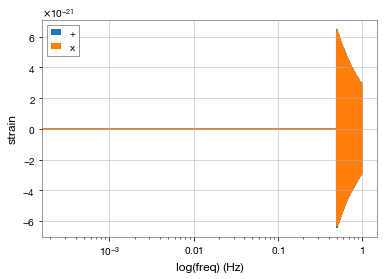

In [13]:
freq = waveform_generator.frequency_array
hplus = waveform_generator.frequency_domain_strain(injection_parameters)['plus']
hcross = waveform_generator.frequency_domain_strain(injection_parameters)['cross']
plt.plot(freq, hplus,label='+')
plt.plot(freq, hcross,label='x')
plt.xlabel('log(freq) (Hz)')
plt.ylabel('strain')
plt.legend()
plt.xscale('log')
plt.savefig('LISA_IMRPhenomPv2_waveform.png', dpi=200)

In [14]:
test=np.fft.irfft(hplus)

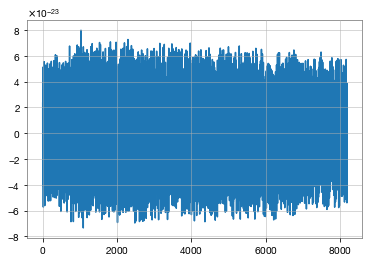

In [21]:
from scipy.signal.windows import tukey
test=np.fft.irfft(hplus*tukey(hplus.size,alpha=0.8))
plt.plot(test)
